In [ ]:
# based on Sebastian Raschka jupyter notebook
# git with several models: https://github.com/rasbt/deeplearning-models
# model used: Multilayer Perceptron
# https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/mlp/mlp-basic.ipynb

In [1]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import pickle
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.1
num_epochs = 10
batch_size = 64

# Architecture
num_features = 1080 #size of the pic, 30 * 36
num_hidden_1 = 128
num_hidden_2 = 256
num_classes = 2 #seperate sleep and wakefulness

In [3]:
# help functions
pickle_path = '/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/Hour'
time_window_hours = 1
time_window_ms = time_window_hours * 60.0 * 60 * 1000

# get the data from the relevant pickle file
def get_pickle_file(hour):
    infile = open(pickle_path + str(hour),'rb')
    pc_pymat = pickle.load(infile)
    infile.close()
    return pc_pymat

# preform fourie transform using welch
def welch_fft_on_data(pc_pymat): 
    freq_power = []
    for i in range(360):
        single_bin = pc_pymat[i * 200000:200000*(i+1)]
        f, Pxx_den = signal.welch(single_bin, 20000, nperseg=20000, noverlap=10000, scaling='spectrum')
        freq_power.append(Pxx_den)

    freq_power = np.array(freq_power)
    
    # normalized spectogram data - norm power of each frequency with it's avarage power
    low_freq_power = freq_power[:,:30]
    avg_freq_power = np.array([0.0]*30)
    # calculate avarage power of the freq
    for i in range(30):
        avg_freq_power[i] = sum(low_freq_power[:,i]) / low_freq_power.shape[0]

    # create the normalized matrix
    norm_freq_power = []
    for seg in low_freq_power:
        new_seg = np.array([0.0]*30)
        for i in range(30):
            new_seg[i] = seg[i] / avg_freq_power[i]
        norm_freq_power.append(new_seg)

    norm_freq_power = np.array(norm_freq_power)
    return f, norm_freq_power

# the good samples- after all processing
def generate_train_test_data_to_pickle():
    train_data = []
    h_test_sleep = np.random.randint(3,9,1)[0]
    # get sleep train data
    for i in range(3,9):
        if i == h_test_sleep:
            continue
        pc_pymat = get_pickle_file(i)
        _ , freq_power = welch_fft_on_data(pc_pymat)
        samples_max = freq_power.shape[0] - 36
        for j in range(samples_max):
            datum = torch.from_numpy(freq_power[i:i+36,:])
            lable = 1            
            train_data.append((datum, lable))

    # get awake train data (after first sleep)
    h_test_awake = np.random.randint(11,15,1)[0]
    for i in range(11,15):
        if i == h_test_awake:
            continue
        pc_pymat = get_pickle_file(i)
        _ , freq_power = welch_fft_on_data(pc_pymat)
        samples_max = freq_power.shape[0] - 36
        for j in range(samples_max):
            datum = torch.from_numpy(freq_power[i:i+36,:])
            lable = 0
            train_data.append((datum, lable))

    test_data = []
    for i in [h_test_sleep,h_test_awake]:
        pc_pymat = get_pickle_file(i)
        _ , freq_power = welch_fft_on_data(pc_pymat)
        samples_max = freq_power.shape[0] - 36
        for j in range(samples_max):
            datum = torch.from_numpy(freq_power[i:i+36,:])
            lable = 0 if i==h_test_awake else 1
            test_data.append((datum, lable))
    print([h_test_sleep,h_test_awake])
    # save train data to pickle
    filename = '/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/train_dataset'
    outfile = open(filename,'wb')
    pickle.dump(train_data,outfile)
    outfile.close()
    
    # save test data to pickle
    filename = '/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/test_dataset'
    outfile = open(filename,'wb')
    pickle.dump(test_data,outfile)
    outfile.close()
    
    return train_data, test_data
    
# get from pickle the train and test data generated using 'generate_train_test_data_to_pickle()'   
def get_train_test_data():
    infile = open('/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/train_dataset','rb')
    train_dataset = pickle.load(infile)
    infile.close()
    infile = open('/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/test_dataset','rb')
    test_dataset = pickle.load(infile)
    infile.close()
    return train_dataset, test_dataset

In [4]:
# pc_pymat = get_pickle_file(7)
# f7, freq_power7 = welch_fft_on_data_noNorm(pc_pymat)
# pc_pymat = get_pickle_file(14)
# f14, freq_power14 = welch_fft_on_data_noNorm(pc_pymat)

In [5]:
# #plot spectogram before processing it
# plt.figure(figsize=(1,5))
# plt.pcolormesh([i for i in range(36)], f14[:30], np.abs(np.log(np.transpose(freq_power14[:36,:30]))), shading='gouraud')
# plt.title('STFT Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [fourie bins]')
# plt.show()

In [6]:
# #plot spectogram before processing it
# plt.figure(figsize=(1,5))
# plt.pcolormesh([i for i in range(36)], f7[:30], np.abs(np.log(np.transpose(freq_power7[:36,:30]))), shading='gouraud')
# plt.title('STFT Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [fourie bins]')
# plt.show()

In [7]:
##########################
### DATASET
##########################
# train_dataset, test_dataset = generate_train_test_data_to_pickle() #in comment because need to be used only once
# train_data1, test_data1 = generate_train_test_data_to_pickle_noNorm()
train_dataset, test_dataset = get_train_test_data()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=True)
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Image batch dimensions: torch.Size([64, 36, 30])
Image label dimensions: torch.Size([64])


In [8]:
##########################
### MODEL
##########################

class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # demonstrate how to access the weights:
#         self.linear_1.weight.detach().normal_(0.0, 0.1)
#         self.linear_1.bias.detach().zero_()
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        
        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out)
        probas = F.log_softmax(logits, dim=1)
        return logits, probas
    
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=num_features,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

In [9]:
def compute_accuracy(net, data_loader):
    net.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 30*36).to(device)
            targets = targets.to(device)
            logits, probas = net(features.float())
            _, predicted_labels = torch.max(probas, 1)
#             print('----------------------------------------')
#             print(targets)
#             print(predicted_labels)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

In [10]:
# run the model   
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
#         print(batch_idx)
        features = features.view(-1, 30*36).to(device)
#         features = torch.zeros_like(features)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features.float())
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/041 | Cost: 0.6572
Epoch: 001/010 training accuracy: 100.00%
Time elapsed: 0.01 min
Epoch: 002/010 | Batch 000/041 | Cost: 0.4629
Epoch: 002/010 training accuracy: 100.00%
Time elapsed: 0.01 min
Epoch: 003/010 | Batch 000/041 | Cost: 0.0094
Epoch: 003/010 training accuracy: 100.00%
Time elapsed: 0.02 min
Epoch: 004/010 | Batch 000/041 | Cost: 0.0017
Epoch: 004/010 training accuracy: 100.00%
Time elapsed: 0.02 min
Epoch: 005/010 | Batch 000/041 | Cost: 0.0010
Epoch: 005/010 training accuracy: 100.00%
Time elapsed: 0.02 min
Epoch: 006/010 | Batch 000/041 | Cost: 0.0005
Epoch: 006/010 training accuracy: 100.00%
Time elapsed: 0.03 min
Epoch: 007/010 | Batch 000/041 | Cost: 0.0005
Epoch: 007/010 training accuracy: 100.00%
Time elapsed: 0.03 min
Epoch: 008/010 | Batch 000/041 | Cost: 0.0003
Epoch: 008/010 training accuracy: 100.00%
Time elapsed: 0.04 min
Epoch: 009/010 | Batch 000/041 | Cost: 0.0003
Epoch: 009/010 training accuracy: 100.00%
Time elapsed: 0.04 min
E

In [11]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 100.00%


# Saliency Map Sleep

In [12]:
# help functions
pickle_path = '/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/Hour'
time_window_hours = 1
time_window_ms = time_window_hours * 60.0 * 60 * 1000

# the good samples- after all processing
def generate_train_test_data_to_pickle_sleep_awake(isSleep, state):
    # lizard 1
    # -----------------------------------------------------------
    pickle_path = '/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/Hour'
    train_data = []
    # get sleep train data
#     arr = range(3,9) if isSleep else range(11,15) 
    arr = [7] if isSleep else [14]
    lable = 1 if isSleep else 0
    for i in arr:
        pc_pymat = get_pickle_file(i)
        _ , freq_power = welch_fft_on_data(pc_pymat)
        samples_max = freq_power.shape[0] - 36
        for j in range(samples_max):
            datum = torch.from_numpy(freq_power[i:i+36,:])         
            train_data.append((datum, lable))    
    
    # save train data to pickle
    filename = '/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/' + state + '_dataset'
    outfile = open(filename,'wb')
    pickle.dump(train_data,outfile)
    outfile.close()
    
    return train_data
    
# get from pickle the train and test data generated using 'generate_train_test_data_to_pickle()'   
def get_train_test_data_sleep_awake(state):
    infile = open('/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/' + state + '_dataset','rb')
    train_dataset = pickle.load(infile)
    infile.close()

    return train_dataset

sleep_dataset = get_train_test_data_sleep_awake('sleep')

awake_dataset = get_train_test_data_sleep_awake('awake')

In [13]:
# generate_train_test_data_to_pickle_sleep_awake(True, 'sleep')
# generate_train_test_data_to_pickle_sleep_awake(False, 'awake')

In [26]:
sleep_loader = DataLoader(dataset=sleep_dataset, 
                          batch_size=1, 
                          shuffle=True)

awake_loader = DataLoader(dataset=awake_dataset, 
                          batch_size=1, 
                          shuffle=True)

net = model
# comment out sleep_loader or awake_loader according to the desire seliancy map needed 
data_loader = sleep_loader
# data_loader = awake_loader

net.eval()
correct_pred, num_examples = 0, 0
# with torch.no_grad():
for features, targets in data_loader:
    features = features.view(-1, 30*36)
    features = features.to(device)
    # Set the requires_grad_ to the image for retrieving gradients
    features.requires_grad_()
#     features.retain_grad()
    targets = targets.to(device)

    logits, probas = net(features.float())
    _, predicted_labels = torch.max(probas, 1)
    logits[0][predicted_labels[0]].backward()


    num_examples += targets.size(0)
    correct_pred += (predicted_labels == targets).sum()
    break;
#     return correct_pred.float()/num_examples * 100

In [27]:
# features.grad.data.abs()

In [28]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)

saliency = features.grad.data
# saliency, _ = torch.max(features.grad.data.abs(), dim=1) 
saliency = saliency.reshape(30, 36)

# Reshape the image
features = features.reshape(-1,30, 36)

In [17]:
features1 = features
saliency1 = saliency

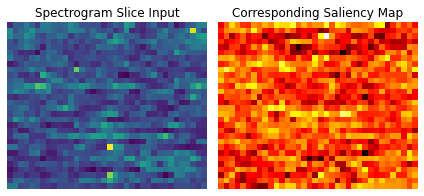

In [25]:
# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(features1.cpu().detach().numpy().transpose(1, 2, 0))
ax[0].axis('off')
ax[0].set_title("Spectrogram Slice Input")
ax[1].imshow(saliency1.cpu(), cmap='hot')
ax[1].axis('off')
ax[1].set_title("Corresponding Saliency Map")
# plt.title('Example of a Saliency Map for Singel Datum - wakefulness state')
plt.tight_layout()
# fig.suptitle('The Image and Its Saliency Map - awake')
plt.show()

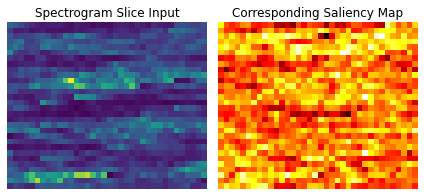

In [30]:
# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(features.cpu().detach().numpy().transpose(1, 2, 0))
ax[0].axis('off')
ax[0].set_title("Spectrogram Slice Input")
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
ax[1].set_title("Corresponding Saliency Map")
plt.tight_layout()
# fig.suptitle('The Image and Its Saliency Map - Sleep')
plt.show()

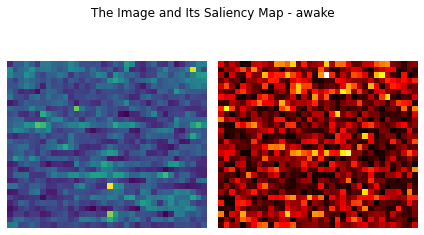

In [17]:
# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(features.cpu().detach().numpy().transpose(1, 2, 0))
ax[0].axis('off')
ax[1].imshow(saliency.cpu().abs(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map - awake')
plt.show()